In [ ]:
import torch
import torch.nn as nn

In [ ]:
GPT_CONFIG_124M = {
    'emb_size':768,
    'context_length':1024,
    'vocab_size':50257,
    'num_heads':12,
    'num_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False,
}

## **GPT Backbone**

In [ ]:
class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb_layer = nn.Embedding(cfg['vocab_size'], cfg['emb_size'])
    self.pos_emb_layer = nn.Embedding(cfg['context_length'], cfg['emb_size'])
    self.drop_layer = nn.Dropout(cfg['drop_rate'])
    self.trf_blocks = nn.Sequential(
        * [DummyTransformerBlock(cfg) for _ in range(cfg['num_layers'])]
    )
    self.final_norm_layer = DummyLayerNormalization(cfg['emb_size'])
    self.output_layer = nn.Linear(cfg['emb_size'], cfg['vocab_size'], bias=False)

  def forward(self, inp_seq):
    batch_size, num_tokens = inp_seq.shape
    token_embeddings = self.token_emb_layer(inp_seq)
    pos_embeddings = self.pos_emb_layer(
        torch.arange(num_tokens, device=inp_seq.device)
    )
    x = token_embeddings + pos_embeddings
    x = self.drop_layer(x)
    x = self.trf_blocks(x)
    x = self.final_norm_layer(x)
    x = self.output_layer(x)

    return x


class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()

  def forward(self, x):
    return x

class DummyLayerNormalization(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

In [ ]:
import tiktoken as tk

tokenizer = tk.get_encoding('gpt2')
txt1 = 'How was your day'
txt2 = 'What is your name'

tokenized_txt1 = torch.tensor(tokenizer.encode(txt1))
tokenized_txt2 = torch.tensor(tokenizer.encode(txt2))

batch_inp = torch.stack((tokenized_txt1, tokenized_txt2))

print(batch_inp)

tensor([[2437,  373,  534, 1110],
        [2061,  318,  534, 1438]])


In [ ]:
dgm = DummyGPTModel(GPT_CONFIG_124M)
print(dgm(batch_inp).shape)

torch.Size([2, 4, 50257])


## **Layer Normalization**

In [ ]:
torch.manual_seed(123)
sample_inp = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
output = layer(sample_inp)
print(output)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
mean = output.mean(dim=-1, keepdim=True)
variance = output.var(dim=-1, keepdim=True)

print("Mean: ", mean)
print("Variance: ", variance)

Mean:  tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:  tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
#lets normalize the output
torch.set_printoptions(sci_mode=False)
output_norm = (output - mean)/torch.sqrt(variance)
print("Normalized outputs: ",output_norm)
print()
print("Mean: ",output_norm.mean(keepdim=True, dim=-1))
print()
print("Variance: ", output_norm.var(keepdim=True, dim=-1))

Normalized outputs:  tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)

Mean:  tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)

Variance:  tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
#lets implement compact class for normalization
class LayerNorm(nn.Module):
  def __init__(self, emb_size):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_size))
    self.shift = nn.Parameter(torch.zeros(emb_size))

  def forward(self, x):
    mean = x.mean(keepdim=True, dim=-1)
    variance = x.var(keepdim=True, dim=-1, unbiased=False)
    norm_x = (x - mean)/torch.sqrt(variance + self.eps)
    return self.scale * norm_x + self.shift

In [ ]:
norm_layer = LayerNorm(emb_size=5)
output_norm = norm_layer(sample_inp)
print("Normalized outputs: ", output_norm)
print()
print("Mean: ", output_norm.mean(keepdim=True, dim=-1))
print()
print("Variance: ", output_norm.var(unbiased=False, keepdim=True, dim=-1))

Normalized outputs:  tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)

Mean:  tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)

Variance:  tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## **GeLU**

In [ ]:
class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x,3))
    ))

In [ ]:
x = torch.linspace(-3,3,1000)

relu = nn.ReLU()
gelu = GeLU()

y_relu = relu(x)
y_gelu = gelu(x)

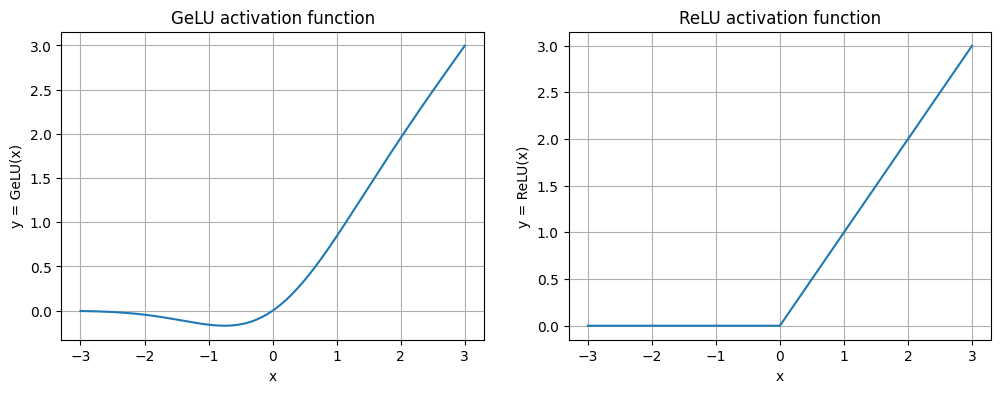

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x, y_gelu)
plt.title("GeLU activation function")
plt.xlabel("x")
plt.ylabel("y = GeLU(x)")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, y_relu)
plt.title("ReLU activation function")
plt.xlabel("x")
plt.ylabel("y = ReLU(x)")
plt.grid()

## **Feed Forward Submodule**

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_size'], 4 * cfg['emb_size']),
        GeLU(),
        nn.Linear(4 * cfg['emb_size'], cfg['emb_size'])
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
sample_batch_inp = torch.randn(2, 3, 768)

ff = FeedForward(GPT_CONFIG_124M)
print(ff(sample_batch_inp).shape)

torch.Size([2, 3, 768])


## **Shortcut Connections**

Benefit of using shortcut connections in a deep network is stable training through bypassing the layer for gradient flow tackling the vanishing gradient problem

In [ ]:
class ShortcutConnection(nn.Module):
  def __init__(self, layers_size: list):
    super().__init__()
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layers_size[0],layers_size[1]),
                      GeLU()),
        nn.Sequential(nn.Linear(layers_size[1],layers_size[2]),
                      GeLU()),
        nn.Sequential(nn.Linear(layers_size[2],layers_size[3]),
                      GeLU()),
        nn.Sequential(nn.Linear(layers_size[3],layers_size[4]),
                      GeLU())
    ])

  def forward(self, x, use_shortcut=False):
    for layer in self.layers:
      output = layer(x)
      if use_shortcut and x.shape==output.shape:
        x = x + output
      else:
        x = output
    return x

In [ ]:
#lets demonstrate a deep network without shortcut connections
layers_size = [4,4,4,4,1]

torch.manual_seed(123)
inp = torch.tensor([[-2.0, -1.0, 1.0, 2.0]])
target = torch.tensor([[0.]])

torch.manual_seed(123)
sc1 = ShortcutConnection(layers_size)
output = sc1(inp)

loss = nn.MSELoss()
loss = loss(output, target)

loss.backward()

for name, param in sc1.named_parameters():
  if 'weight' in name:
    print(f'{name} with absolute mean gradient: {param.grad.abs().mean()}')

layers.0.0.weight with absolute mean gradient: 0.0007469846750609577
layers.1.0.weight with absolute mean gradient: 0.0003280607925262302
layers.2.0.weight with absolute mean gradient: 0.00010278999980073422
layers.3.0.weight with absolute mean gradient: 0.0032764719799160957


In [ ]:
torch.manual_seed(123)
sc2 = ShortcutConnection(layers_size)
output = sc2(inp, use_shortcut=True)

loss = nn.MSELoss()
loss = loss(output, target)

loss.backward()

for name, param in sc2.named_parameters():
  if 'weight' in name:
    print(f'{name} with absolute mean gradient: {param.grad.abs().mean()}')

layers.0.0.weight with absolute mean gradient: 0.004384280648082495
layers.1.0.weight with absolute mean gradient: 0.0036721215583384037
layers.2.0.weight with absolute mean gradient: 0.0022218425292521715
layers.3.0.weight with absolute mean gradient: 0.010970210656523705


## **Building Transformer Block**

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, dim_in, dim_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (dim_out % num_heads == 0), "dim_out must be divisible by num_heads"

    self.dim_out = dim_out # final merged context vector embedding size
    self.num_heads = num_heads
    self.head_dim = dim_out//num_heads # embedding size of context vector in single head
    self.w_query = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_key = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_value = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.out_proj = torch.nn.Linear(dim_out, dim_out) # transform merged context_vectors into similar dimension size vectors
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, dim_in = x.shape
    queries = self.w_query(x)
    keys = self.w_key(x)
    values = self.w_value(x)  #shape (batch_size, num_tokens, dim_out)

    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim) #shape (batch_size, num_tokens, num_heads, head_dim)

    queries = queries.transpose(1,2)
    keys = keys.transpose(1,2)
    values = values.transpose(1,2) #shape (batch_size, num_heads, num_tokens, head_dim)

    attention_scores = queries @ keys.transpose(2,3)
    attention_scores.masked_fill_(self.mask.bool()[:num_tokens,:num_tokens], -torch.inf)

    attention_weights = torch.softmax(attention_scores/keys.shape[-1]**0.5, dim=-1)
    attention_weights = self.dropout(attention_weights)

    context_vectors = (attention_weights @ values).transpose(1,2) #transposing axis 1,2  since we have to merge the context vectors by num_heads and head_dim, so required shape will now be (batch_size, num_tokens, num_heads, head_dim)
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.dim_out)

    context_vectors = self.out_proj(context_vectors)

    return context_vectors

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.mha = MultiHeadAttention(cfg['emb_size'], cfg['emb_size'], cfg['context_length'], cfg['drop_rate'], cfg['num_heads'], qkv_bias=cfg['qkv_bias'])
    self.layer_norm1 = LayerNorm(cfg['emb_size'])
    self.layer_norm2 = LayerNorm(cfg['emb_size'])
    self.ffn = FeedForward(cfg)
    self.dropout = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x
    x = self.layer_norm1(x)
    x = self.mha(x)
    x = self.dropout(x)
    x = x + shortcut

    shortcut = x
    x = self.layer_norm2(x)
    x = self.ffn(x)
    x = self.dropout(x)
    x = x + shortcut

    return x

In [ ]:
torch.manual_seed(123)
trf_block = TransformerBlock(GPT_CONFIG_124M)
sample_inp_trf = torch.rand(2, 4, 768)
output = trf_block(sample_inp_trf)

print(sample_inp_trf.shape)
print(output.shape)

torch.Size([2, 4, 768])
torch.Size([2, 4, 768])


## **GPT Model**

In [ ]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb_layer = nn.Embedding(cfg['vocab_size'], cfg['emb_size'])
    self.pos_emb_layer = nn.Embedding(cfg['context_length'], cfg['emb_size'])
    self.dropout_layer = nn.Dropout(cfg['drop_rate'])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['num_layers'])]
    )
    self.final_norm = LayerNorm(cfg['emb_size'])
    self.output_layer = nn.Linear(cfg['emb_size'], cfg['vocab_size'], bias=False)

  def forward(self, inp_tokens):
    batch_size, num_tokens = inp_tokens.shape
    token_emb = self.token_emb_layer(inp_tokens)
    pos_emb = self.pos_emb_layer(
        torch.arange(num_tokens, device=inp_tokens.device)
    )
    x = token_emb + pos_emb
    x = self.dropout_layer(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.output_layer(x)

    return logits

In [ ]:
import tiktoken as tk

tokenizer = tk.get_encoding('gpt2')
txt1 = 'How was your day'
txt2 = 'What is your name'

tokenized_txt1 = torch.tensor(tokenizer.encode(txt1))
tokenized_txt2 = torch.tensor(tokenizer.encode(txt2))

batch_inp = torch.stack((tokenized_txt1, tokenized_txt2))

print(batch_inp)

tensor([[2437,  373,  534, 1110],
        [2061,  318,  534, 1438]])


In [ ]:
torch.manual_seed(123)
gpt_model = GPTModel(GPT_CONFIG_124M)
output = gpt_model(batch_inp)

print(batch_inp.shape)
print(output.shape)
print(output)

torch.Size([2, 4])
torch.Size([2, 4, 50257])
tensor([[[-0.1630,  0.1162, -0.3858,  ..., -0.3139, -0.4072, -0.5760],
         [ 0.3507,  0.1657,  0.9489,  ..., -0.3826, -1.3417,  0.6272],
         [ 0.7005,  1.4436,  0.1545,  ..., -0.1065, -0.2686, -0.3540],
         [-0.3554,  0.1143,  0.3030,  ...,  1.3152, -1.0592,  0.0177]],

        [[-0.0725, -1.1968,  0.1328,  ..., -0.5604, -0.4485, -0.4617],
         [ 1.0600, -0.9398, -1.0801,  ...,  0.1484,  0.4047, -0.5370],
         [ 0.9350,  0.5404, -0.0233,  ..., -0.1978,  0.2891, -0.2618],
         [-0.5534, -0.8525, -0.2829,  ...,  0.4258, -0.0458, -0.3260]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
#lets calculate number of parameters
total_params = sum(p.numel() for p in gpt_model.parameters())
print("Total parameters in GPT Model: ", total_params)

Total parameters in GPT Model:  163009536


In [ ]:
#lets calculate parameters without considering output layer (since in original GPT-2 124M it reuses the weights of embedding layer)
total_params_gpt = total_params - sum(p.numel() for p in gpt_model.output_layer.parameters())
print("Total parameters in GPT-2 model: ", total_params_gpt)

Total parameters in GPT-2 model:  124412160


In [ ]:
#lets calculate the number of parameters in feed forward and mutlihead-attention module
params_mha = sum(p.numel() for p in gpt_model.trf_blocks[0].mha.parameters())
print(f'Parameters in single multihead-attention module: {params_mha}')

params_ffn = sum(p.numel() for p in gpt_model.trf_blocks[0].ffn.parameters())
print(f'Parameters in feed forward module: {params_ffn}')

Parameters in single multihead-attention module: 2360064
Parameters in feed forward module: 4722432


In [ ]:
#lets calculate parameters in GPT-2 medium
GPT_CONFIG_MEDIUM = {
    'emb_size':1024,
    'context_length':1024,
    'vocab_size':50257,
    'num_heads':16,
    'num_layers':24,
    'drop_rate':0.1,
    'qkv_bias':False,
}

In [ ]:
gpt_medium = GPTModel(GPT_CONFIG_MEDIUM)

In [ ]:
#lets calculate number of parameters
total_params = sum(p.numel() for p in gpt_medium.parameters())
print("Total parameters in GPT Medium Model: ", total_params)

Total parameters in GPT Medium Model:  406212608


In [ ]:
#lets calculate parameter size
param_size_byte = total_params_gpt * 4 #(float 32-bit or 4 bytes)
param_size_mb = param_size_byte/(1024 * 1024)
print(param_size_mb)

474.5947265625


## **Text Generation**

In [ ]:
def generate_text_tokens(model, inp_tokens, max_tokens, context_size):
  for _ in range(max_tokens):
    cropped_tokens = inp_tokens[:,-context_size:]
    with torch.no_grad():
      logits = gpt_model(cropped_tokens)

    logits = logits[:,-1,:]
    prob = torch.softmax(logits, dim=-1)
    token_id = torch.argmax(prob, dim=-1, keepdim=True)
    inp_tokens = torch.cat((inp_tokens, token_id), dim=1)

  return inp_tokens

In [ ]:
text = "What is your plan for"
encoded_text = tokenizer.encode(text)
encoded_tensor = torch.tensor(encoded_text).unsqueeze(0)
encoded_tensor

tensor([[2061,  318,  534, 1410,  329]])

In [ ]:
gpt_model.eval()
output_tokens = generate_text_tokens(gpt_model, encoded_tensor, 6, GPT_CONFIG_124M['context_length'])
print(output_tokens)
print(output_tokens.shape)

tensor([[ 2061,   318,   534,  1410,   329, 22703, 35945,  6524, 31237, 13097,
          6335]])
torch.Size([1, 11])


In [ ]:
output_text = tokenizer.decode(output_tokens.squeeze(0).tolist())
print(output_text)

What is your plan forolia GMO Ref maze innovativerad
